Necessary packages

In [1]:
import sys
print(sys.executable)

/home/vgaya/anaconda3/envs/py_env/bin/python


In [3]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import squidpy as sq
import pandas as pd
import numpy as np

/home/vgaya/anaconda3/envs/py_env/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/vgaya/anaconda3/envs/py_env/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:504: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
/home/vgaya/anaconda3/envs/py_env/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:505: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = partial(_left_exclusive_join_

In [ ]:
from paste2 import PASTE2, projection, model_selection

In [6]:
from scipy.spatial import distance
from paste2.helper import kl_divergence, intersect, to_dense_array, extract_data_matrix, generalized_kl_divergence, \
    high_umi_gene_distance, pca_distance, glmpca_distance

def partial_pairwise_align_histology(sliceA, sliceB, alpha=0.1, s=None, armijo=False, dissimilarity='glmpca', use_rep=None, G_init=None, a_distribution=None,
                   b_distribution=None, norm=True, return_obj=False, verbose=False, **kwargs):
    """
    Optimal partial alignment of two slices using both gene expression and histological image information.

    sliceA, sliceB must be AnnData objects that contain .obsm['rgb'], which stores the RGB value of each spot in the histology image.
    """
    m = s
    print("PASTE2 starts...")

    # subset for common genes
    common_genes = intersect(sliceA.var.index, sliceB.var.index)
    sliceA = sliceA[:, common_genes]
    sliceB = sliceB[:, common_genes]
    # print('Filtered all slices for common genes. There are ' + str(len(common_genes)) + ' common genes.')

    # Calculate spatial distances
    D_A = distance.cdist(sliceA.obsm['spatial'], sliceA.obsm['spatial'])
    D_B = distance.cdist(sliceB.obsm['spatial'], sliceB.obsm['spatial'])

    # Calculate expression dissimilarity
    A_X, B_X = to_dense_array(extract_data_matrix(sliceA, use_rep)), to_dense_array(extract_data_matrix(sliceB, use_rep))
    if dissimilarity.lower() == 'euclidean' or dissimilarity.lower() == 'euc':
        M_exp = distance.cdist(A_X, B_X)
    elif dissimilarity.lower() == 'kl':
        s_A = A_X + 0.01
        s_B = B_X + 0.01
        M_exp = kl_divergence(s_A, s_B)
    elif dissimilarity.lower() == 'glmpca':
        M_exp = glmpca_distance(A_X, B_X, latent_dim=50, filter=True, verbose=verbose)
    else:
        print("ERROR")
        exit(1)

    # Calculate RGB dissimilarity
    # sliceA_rgb = (sliceA.obsm['rgb'] - np.mean(sliceA.obsm['rgb'], axis=0)) / np.std(sliceA.obsm['rgb'], axis=0)
    # sliceB_rgb = (sliceB.obsm['rgb'] - np.mean(sliceB.obsm['rgb'], axis=0)) / np.std(sliceB.obsm['rgb'], axis=0)
    M_rgb = distance.cdist(sliceA.obsm['rgb'], sliceB.obsm['rgb'])
    # M_rgb = distance.cdist(sliceA_rgb, sliceB_rgb)

    # Scale M_exp and M_rgb, obtain M by taking half from each
    M_rgb /= M_rgb[M_rgb > 0].max()
    M_rgb *= M_exp.max()
    # M_exp /= M_exp[M_exp > 0].max()
    # M_rgb /= M_rgb[M_rgb > 0].max()
    
    M = 0 * M_exp + 1 * M_rgb               ### line 345
    # M = 0.5 * M_exp + 0.5 * M_rgb 

    # init distributions
    if a_distribution is None:
        a = np.ones((sliceA.shape[0],)) / sliceA.shape[0]
    else:
        a = a_distribution

    if b_distribution is None:
        b = np.ones((sliceB.shape[0],)) / sliceB.shape[0]
    else:
        b = b_distribution

    if norm:
        D_A /= D_A[D_A > 0].min().min()
        D_B /= D_B[D_B > 0].min().min()

        """
        Code for normalizing distance matrix
        """
        D_A /= D_A[D_A>0].max()
        D_A *= M.max()
        D_B /= D_B[D_B>0].max()
        D_B *= M.max()
        """
        Code for normalizing distance matrix ends
        """

    # Run OT
    pi, log = partial_fused_gromov_wasserstein(M, D_A, D_B, a, b, alpha=alpha, m=m, G0=G_init, loss_fun='square_loss', armijo=armijo, log=True, verbose=verbose)

    if return_obj:
        return pi, log['partial_fgw_cost']
    return pi


In [ ]:
carpetaData = "../07.PASTE2/"
saveData = "../07.PASTE2/alignAnnData/"

In [ ]:
"""
options = ["19", "MIX"]
print("Select which patient do you want to align:\n(patient 19 refers to three different slices from patient 19 and\npatient MIX refers to three different samples from different patients,\nin both choices the alignment would be performed to the same slice from patient 19\nwhich is considered as the reference)\n")
for i, option in enumerate(options, start=1):
    print(f"{i}. {option}") 
choice = int(input("\nEnter the number of your choice: "))
while choice < 1 or choice > len(options):
    print("\nInvalid choice. Please try again.")
    choice = int(input("\nEnter the number of your choice: "))

patient = options[choice - 1]
"""

Select which patient do you want to align:
(patient 19 refers to three different slices from patient 19 and
patient MIX refers to three different samples from different patients,
in both choices the alignment would be performed to the same slice from patient 19
which is considered as the reference)

1. 19
2. MIX


In [21]:
patient = "19"

patient_1_name = f"{carpetaData}Paciente{patient}_merge_1.h5ad"
patient_1 = sc.read_h5ad(patient_1_name)

patient_2_name = f"{carpetaData}Paciente{patient}_merge_2.h5ad"
patient_2 = sc.read_h5ad(patient_2_name)

patient_3_name = f"{carpetaData}Paciente{patient}_merge_3.h5ad"
patient_3 = sc.read_h5ad(patient_3_name)

patient_4_name = f"{carpetaData}Paciente{patient}_merge_4.h5ad"
patient_4 = sc.read_h5ad(patient_4_name)

In [22]:
patient_1.obsm['spatial']


array([[ 3312,  1309],
       [13023, 11134],
       [ 6360,  1899],
       ...,
       [ 4554, 10151],
       [ 6135, 15653],
       [ 7264,  2685]])

In [29]:
patient_1.X = patient_1.X.astype('int32')
patient_2.X = patient_2.X.astype('int32')

In [ ]:
s_12 = model_selection.select_overlap_fraction(patient_1, patient_2)
pi_12 = PASTE2.partial_pairwise_align(patient_1, patient_2, s = s_12)

new_12 = projection.partial_stack_slices_pairwise([patient_1, patient_2], [pi_12])
patient_1_align12 = new_12[0]
patient_2_align12 = new_12[1]

patient_1_align12.write(f"{saveData}Paciente{patient}_merge_1_align12.h5ad")
patient_2_align12.write(f"{saveData}Paciente{patient}_merge_2_align12.h5ad")

In [ ]:
sq.pl.spatial_scatter(
    adatas[0],
    size = 1.5,
    color='percent.butterfly',
    figsize= (5, 5)
)
sq.pl.spatial_scatter

NameError: name 'sq' is not defined

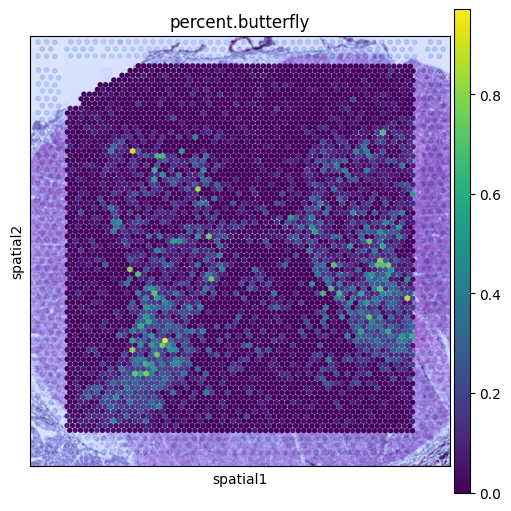

In [21]:
sq.pl.spatial_scatter(
    adatas[1],
    size = 1.5,
    color='percent.butterfly',
    figsize= (5, 5)
)

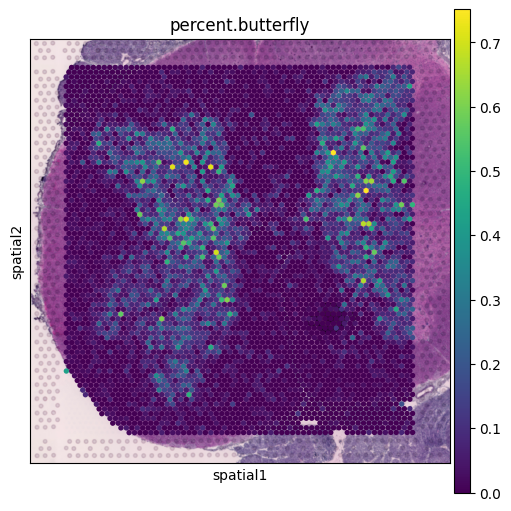

In [17]:
sq.pl.spatial_scatter(
    adatas[2],
    size = 1.5,
    color='percent.butterfly',
    figsize= (5, 5)
)

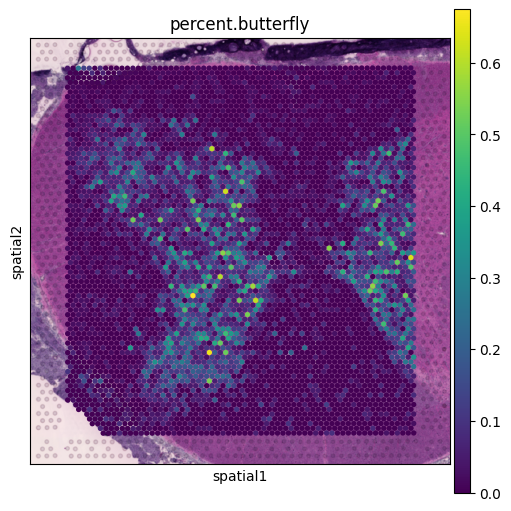

In [18]:
sq.pl.spatial_scatter(
    adatas[3],
    size = 1.5,
    color='percent.butterfly',
    figsize= (5, 5)
)